In [29]:
# Import relevant libraries

%reload_ext autoreload
%autoreload 2

# Base flatland environment
from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import SparseRailGen
from flatland_cutils import TreeObsForRailEnv as TreeCutils
from flatland.envs.observations import GlobalObsForRailEnv

from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.distance_map import DistanceMap
import flatland.envs.rail_env_shortest_paths as sp

# Observation utils and custom policies
from observation_utils import *
from models import *
from deep_model_policy import DeepPolicy, PolicyParameters
from impl_config import FeatureParserConfig as fp

# Training and testing
from training import train_agent
import test_utils

# Visualization
from flatland.utils.rendertools import RenderTool

# Miscellaneous
import numpy as np
import matplotlib.pyplot as plt
import time

## Environment

In [3]:
# Create the environment

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, # Only one agent
    obs_builder_object=GlobalObsForRailEnv(),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

/Users/romaindufly/miniforge3/lib/python3.9/site-packages/flatland/utils/rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(


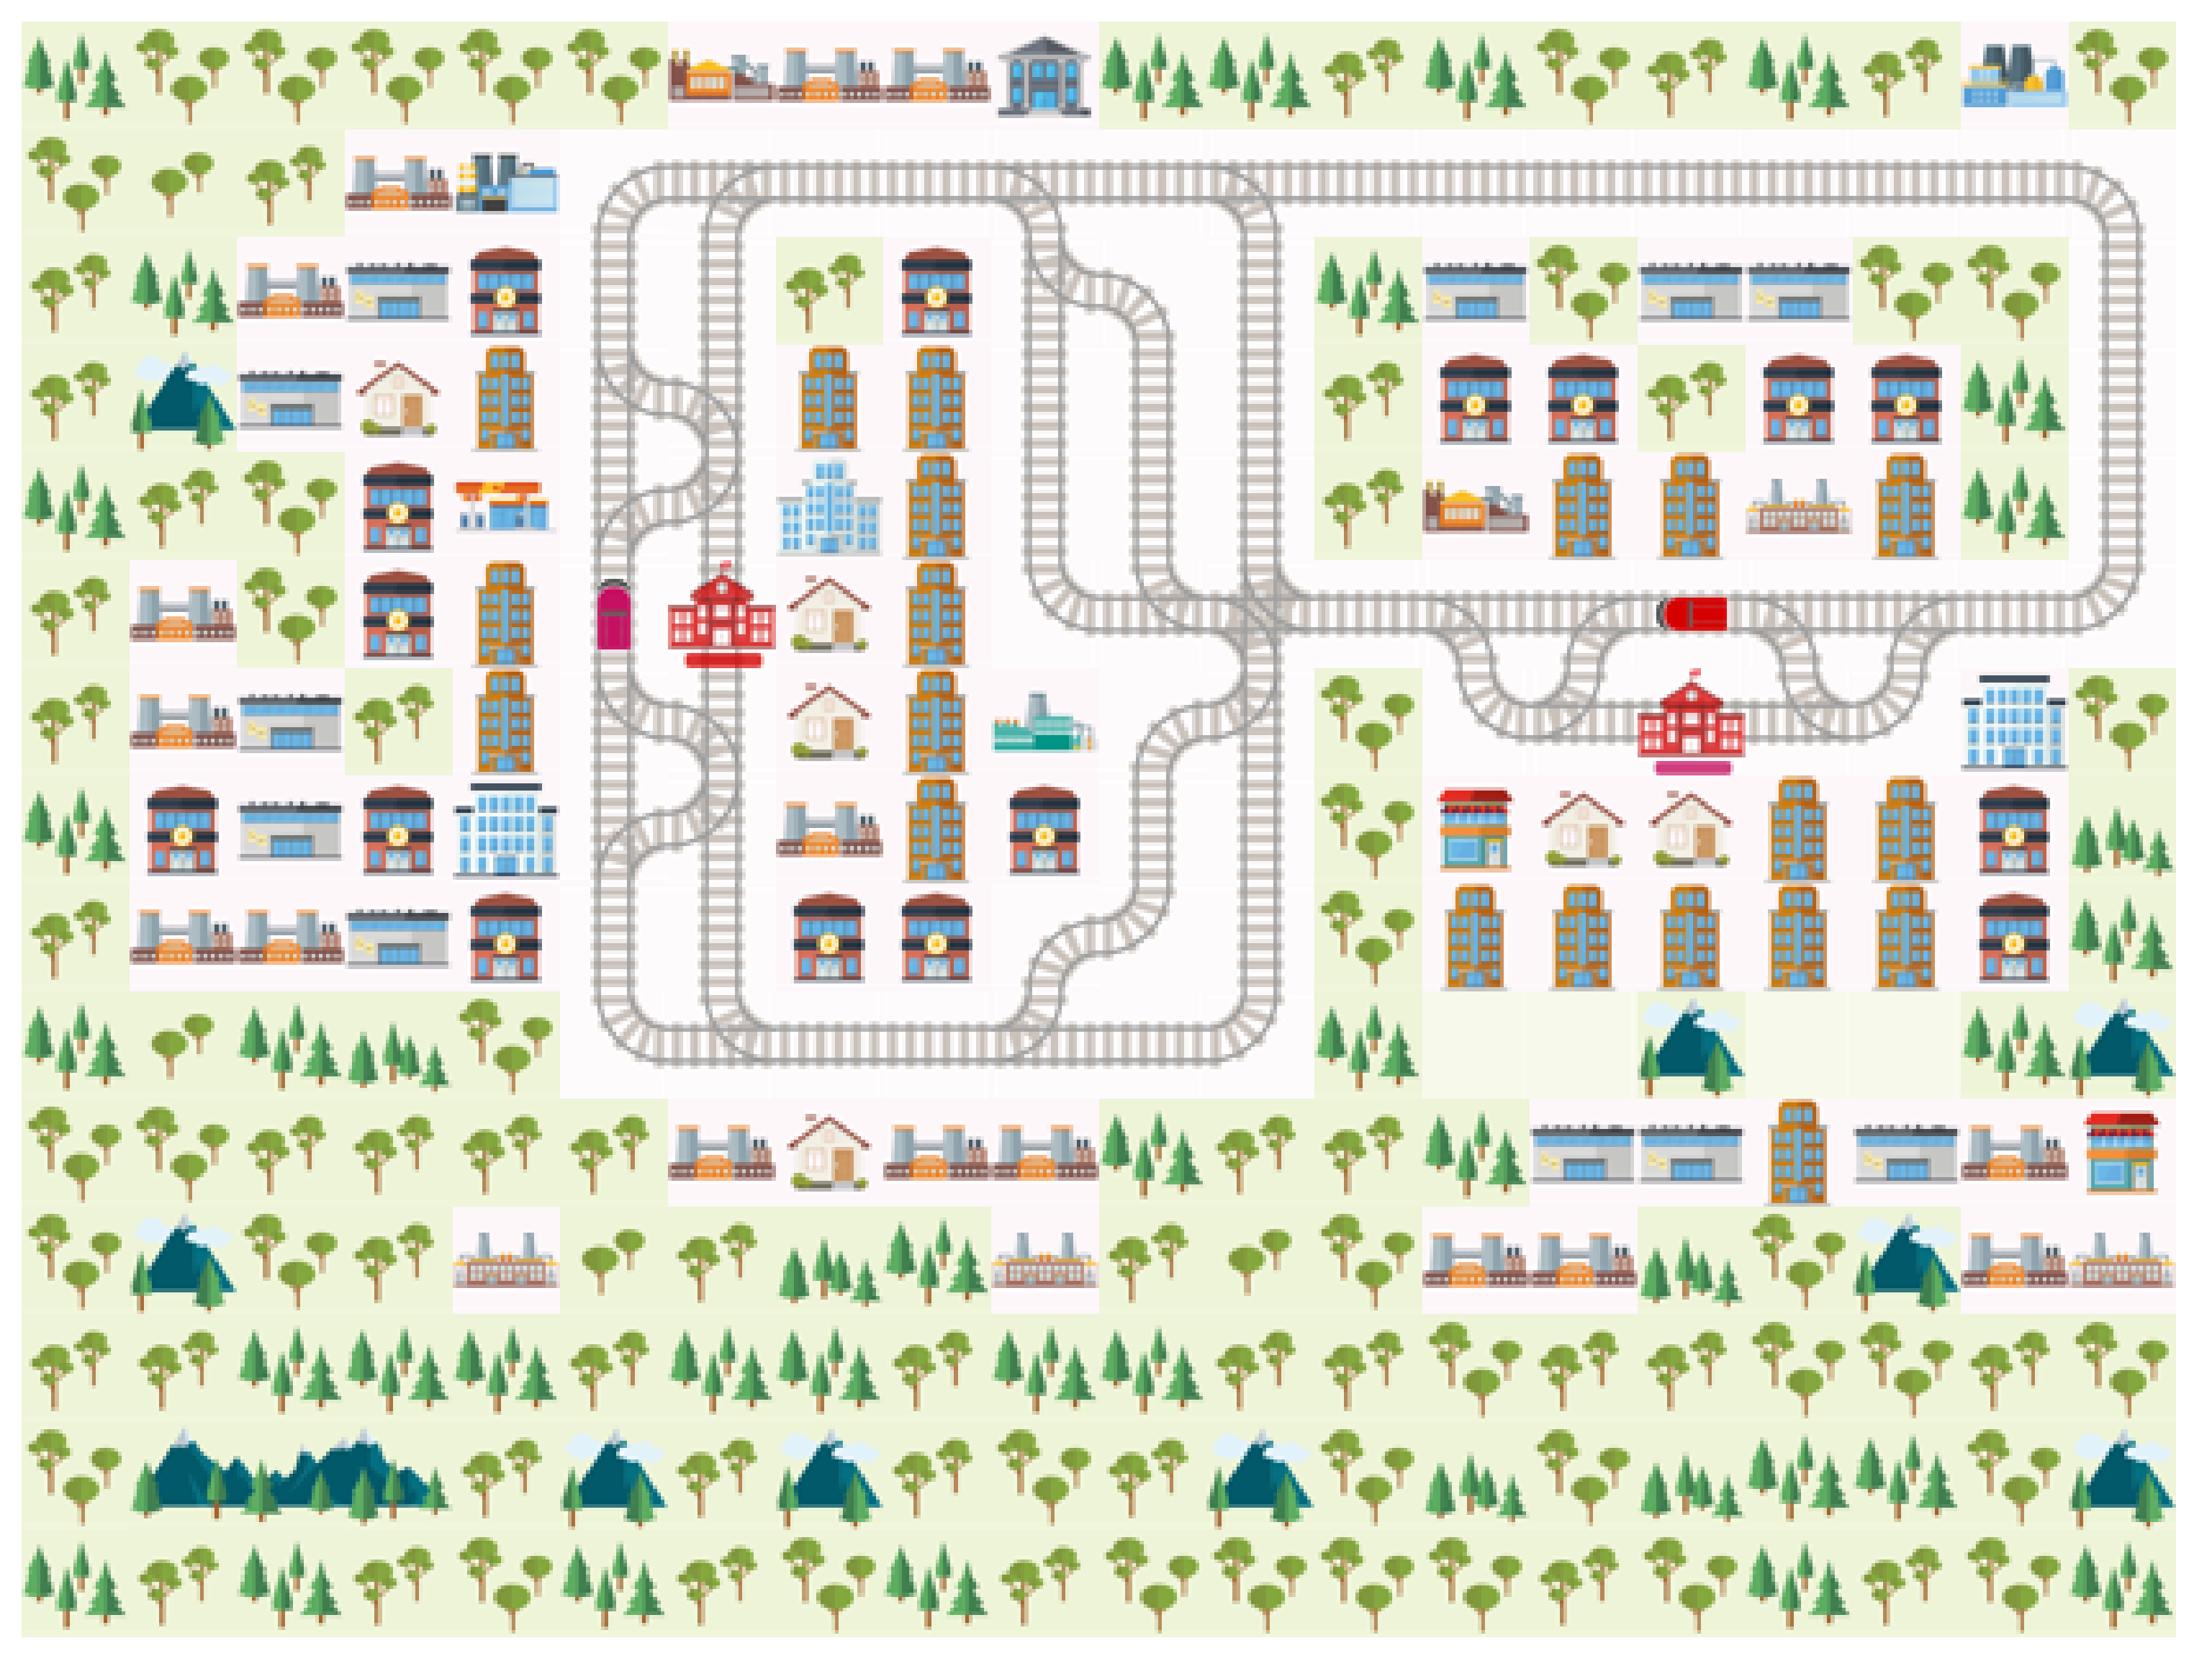

In [4]:
# First basic rendering with inactive agents

env.reset()
env_renderer = RenderTool(env)
image = env_renderer.render_env(return_image=True, show_inactive_agents=True)

plt.figure(figsize=(20, 10), dpi=300)
plt.axis('off')
plt.imshow(image)
plt.show()

In [4]:
# Display information on the environment (agents and their timetable, start position, etc)
for a in env.agents:
    print("Initial agent position: ", a.initial_position)
    print("Initial agent direction: ", a.initial_direction)
    print("Initial agent target: ", a.target)
    # ...

Initial agent position:  (5, 15)
Initial agent direction:  1
Initial agent target:  (5, 6)
Initial agent position:  (5, 5)
Initial agent direction:  0
Initial agent target:  (6, 15)


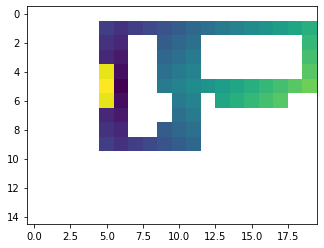

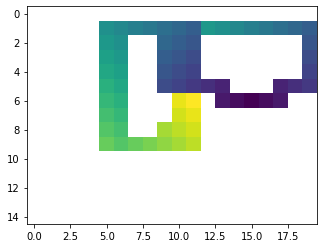

{0: 2, 1: 2}


In [5]:
env.reset()

def get_shortest_paths(env, vis=False):
    distance_map = DistanceMap(env.agents, env.width, env.height)
    distance_map.reset(env.agents, env.rail)
    distance_map.get()

    # Visualize the distance map
    if vis:
        sp.visualize_distance_map(distance_map, 0)
        sp.visualize_distance_map(distance_map, 1)

    shortest_paths = sp.get_shortest_paths(distance_map)
    for handle in shortest_paths.keys():
        if len(shortest_paths) <= 1:
            shortest_paths[handle] = 2
        elif env.agents[handle].position is None:
            shortest_paths[handle] = 2 # Forward = start moving in the map
        else:
            next_cell = shortest_paths[handle][1] # Next cell to visit
            shortest_paths[handle] = sp.get_action_for_move(env.agents[handle].position, 
                                                        env.agents[handle].direction,
                                                        next_cell.position,
                                                        next_cell.direction,
                                                        env.rail)
    return shortest_paths

# Test the shortest path function
actions = get_shortest_paths(env, vis=True)
print(actions)

Initial agent position:  (25, 16)
Initial agent direction:  1
Initial agent target:  (7, 26)
Step 0
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 1
Actions {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2}
Step 2
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: 2}
Step 3
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: <RailEnvActions.MOVE_FORWARD: 2>}
Step 4
Actions {0: 2, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: <RailEnvActions.MOVE_FORWARD: 2>}
Step 5
Actions {0: <RailEnvActions.MOVE_FORWARD: 2>, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 7: <RailEnvActions.MOVE_FORWARD: 2>}
Step 6
Actions {0: <RailEnvActions.MOVE_FORWARD: 2>, 1: 2, 2: <RailEnvActions.MOVE_FORWARD: 2>, 3: <RailEnvActions.MOVE_FORWARD: 2>, 4: 2, 5: 2, 6: 2, 

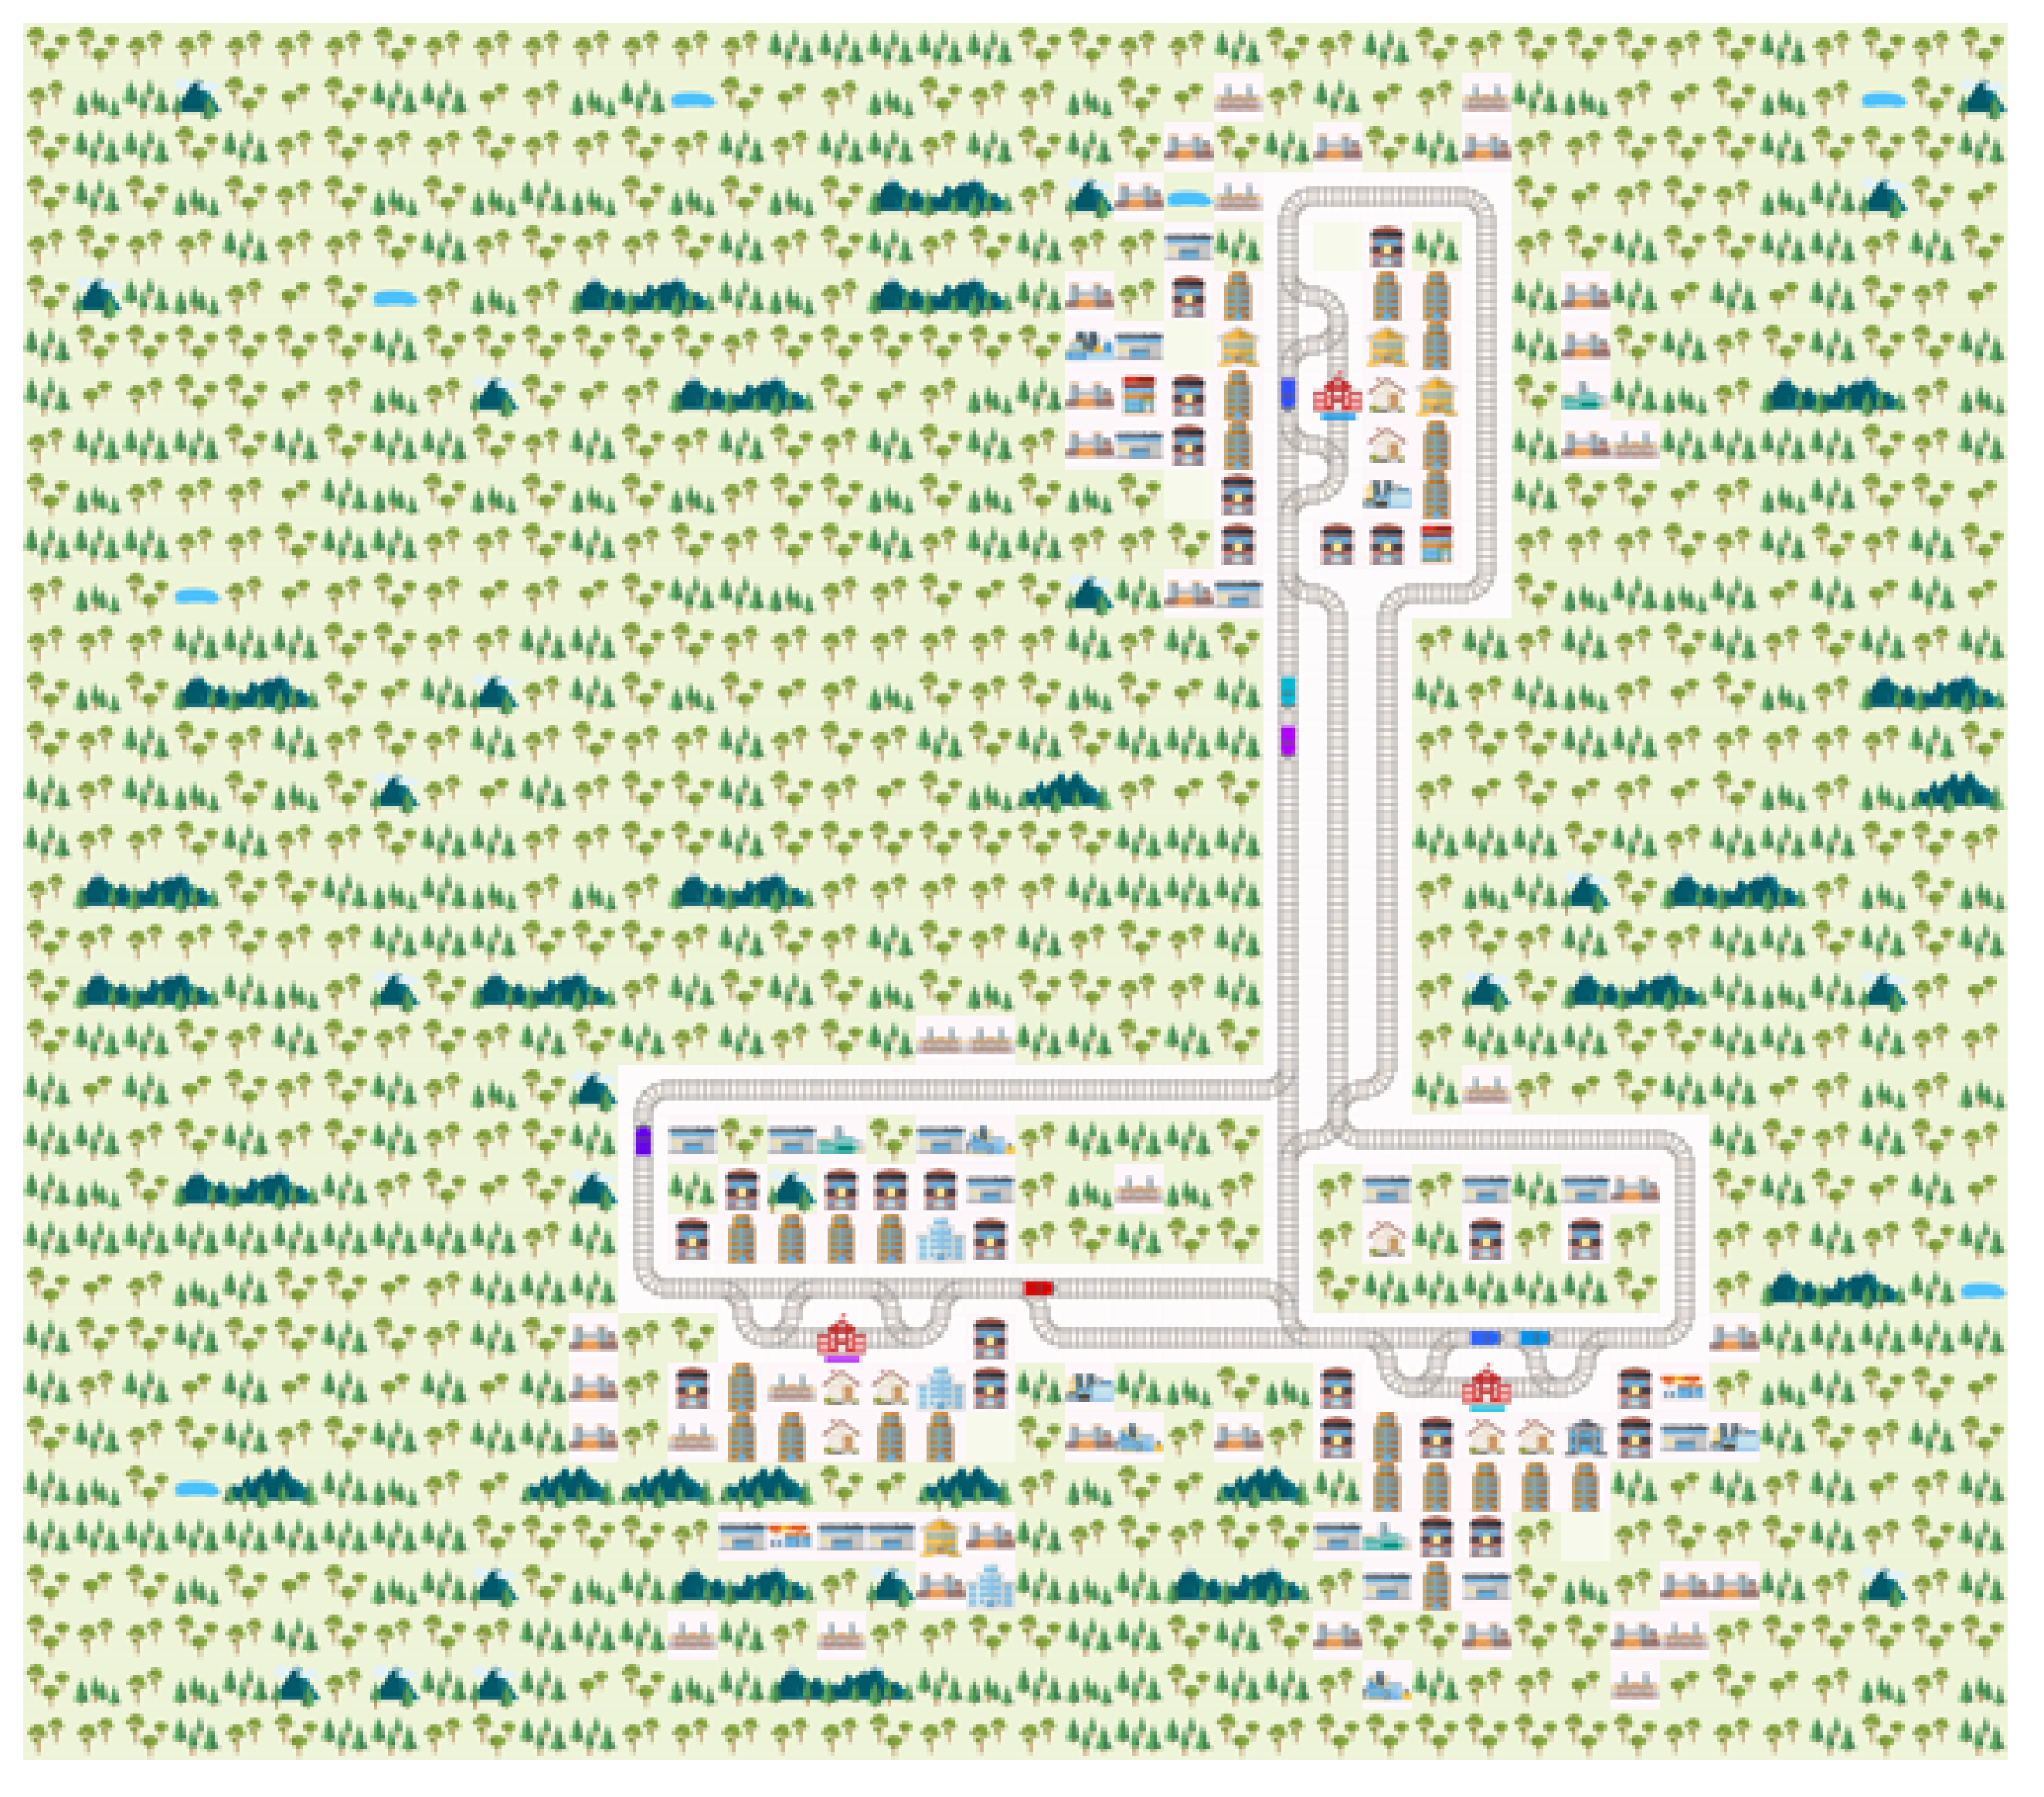

In [6]:
class SingleAgentShortest(TreeObsForRailEnv):
    '''Implements shortest path observation for the agents.'''
    def __init__(self):
        super().__init__(max_depth=0)

    def reset(self):
        super().reset()

    def get(self, handle):
        return get_shortest_paths(self.env)[handle]

# Create the environment
env = RailEnv(
    width=40,
    height=35,
    rail_generator=SparseRailGen(
        seed=0,  # Random seed
        max_num_cities=3,  # Number of cities
        grid_mode=False,
        max_rails_between_cities=1,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.},
        seed=0,  # Random seed
        ),
    number_of_agents=8,
    obs_builder_object=SingleAgentShortest(),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

obs, info = env.reset()
# Print initial position for agent 0
a = env.agents[0]
print("Initial agent position: ", a.initial_position)
print("Initial agent direction: ", a.initial_direction)
print("Initial agent target: ", a.target)

# Step loop
for step in range(10):
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = obs[handle]
    print("Step", step)
    print("Actions", actions)
    obs, all_rewards, done, _ = env.step(actions)

# Agent's info for agent 0
print(a)
print(obs[a.handle])

# Render the final environment
env_renderer = RenderTool(env)
image = env_renderer.render_env(return_image=True, show_inactive_agents=True)
plt.figure(figsize=(20, 10), dpi=300)
plt.axis('off')
plt.imshow(image)
plt.show()

In [95]:
# Step loop with video rendering, shortest path policy

obs, info = env.reset()
env_renderer = RenderTool(env)
env_renderer.render_env(show=True, frames=True)

while True:
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = obs[handle]
    obs, all_rewards, done, _ = env.step(actions)
    env_renderer.render_env(show=True)
    time.sleep(0.1)
    if done['__all__']:
        env_renderer.render_env(show=True, frames=True)
        time.sleep(0.3)
        env_renderer.render_env(show=True, frames=True)
        time.sleep(0.3)
        break

/Users/romaindufly/miniforge3/lib/python3.9/site-packages/flatland/utils/rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(


open_window - pyglet


## Custom build policies

### DuelingQNetwork

In [11]:
%reload_ext autoreload
%autoreload 2

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)
observation_tree_depth = 3
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size)
policy = DeepPolicy(model, policy_params)

# Test the policy output
obs, info = env.reset()

# Get the state by normalizing the observation
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

# Test the policy (debugging)
for agent in env.get_agent_handles():
    action = policy.act(agent_obs[agent], eps=0)

Using CPU


In [3]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.995,
    "n_episodes": 400,
    "checkpoint_interval": 50,
    "n_eval_episodes": 10,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 0/100000 experiences

🚉 Training 2 trains on 20x15 grid for 400 episodes, evaluating on 10 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.765 Avg: -0.998	 💯 Done: 0.00% Avg: 0.00%	 🎲 Epsilon: 0.995 	 🔀 Action Probs: ↻ 0.167 ← 0.197 ↑ 0.182 → 0.227 ◼ 0.227  	✅ Eval: score -0.583 done 0.0%
	🔍 Evaluation score: -0.583 done: 0.0%
🚂 Episode 50	 🏆 Score: -0.697 Avg: -0.853	 💯 Done: 0.00% Avg: 5.72%	 🎲 Epsilon: 0.774 	 🔀 Action Probs: ↻ 0.234 ← 0.188 ↑ 0.156 → 0.141 ◼ 0.281    	✅ Eval: score -0.571 done 0.0%
	🔍 Evaluation score: -0.571 done: 0.0%
🚂 Episode 100	 🏆 Score: -0.475 Avg: -0.771	 💯 Done: 0.00% Avg: 7.95%	 🎲 Epsilon: 0.603 	 🔀 Action Probs: ↻ 0.105 ← 0.158 ↑ 0.079 → 0.105 ◼ 0.553   	✅ Eval: score -0.559 done 0.0%
	🔍 Evaluation score: -0.559 done: 0.0%
🚂 Episode 150	 🏆 Score: -0.456 Avg: -0.694	 💯 Done: 50.00% Avg: 12.20%	 🎲 Epsilon: 0.469 	 🔀 Action Probs: ↻ 0.086 ← 0.534 ↑ 0.172 → 0.138 ◼ 0.069  	✅ Eval: score -0.384 done 35.0%
	🔍 Evaluation score: -0

	✅ Eval: score -0.534 done 18.5%


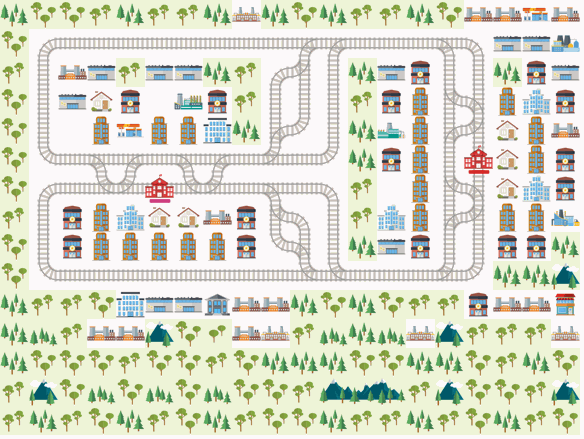

In [5]:
# Test the policy
n_test = 100
scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=best_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

### LSTM QNetwork

In [32]:
policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeCutils(fp.num_tree_obs_nodes, fp.tree_pred_path_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

model = LSTMQNetwork()
policy = DeepPolicy(model, policy_params)

## Test the policy output
obs, info = env.reset()

from observation_utils import normalize_cutils, get_features

obs_list = normalize_cutils(obs, env)

features = get_features(obs_list)
logits = model(*features)[0][0]
logits = logits.squeeze().detach().numpy()

Using CPU


In [33]:
logits

array([ 0.00264582, -0.00513981,  0.00079043,  0.00058606, -0.01018038],
      dtype=float32)

In [35]:
# Train the policy
obs_params = {
    "observation_tree_depth": 3,
    "observation_radius": 10,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.99,
    "n_episodes": 200,
    "checkpoint_interval": 50,
    "n_eval_episodes": 10,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
    "LSTM" : True
}

train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 472/100000 experiences

🚉 Training 2 trains on 20x15 grid for 200 episodes, evaluating on 10 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.511 Avg: -0.995	 💯 Done: 50.00% Avg: 0.50%	 🎲 Epsilon: 0.990 	 🔀 Action Probs: ↻ 0.220 ← 0.183 ↑ 0.244 → 0.207 ◼ 0.146  	✅ Eval: score -0.448 done 25.0%
	🔍 Evaluation score: -0.448 done: 25.0%
🚂 Episode 50	 🏆 Score: -0.618 Avg: -0.866	 💯 Done: 0.00% Avg: 7.14%	 🎲 Epsilon: 0.599 	 🔀 Action Probs: ↻ 0.136 ← 0.182 ↑ 0.258 → 0.288 ◼ 0.136   	✅ Eval: score -0.607 done 0.0%
	🔍 Evaluation score: -0.607 done: 0.0%
🚂 Episode 100	 🏆 Score: -0.333 Avg: -0.737	 💯 Done: 0.00% Avg: 10.55%	 🎲 Epsilon: 0.362 	 🔀 Action Probs: ↻ 0.078 ← 0.250 ↑ 0.156 → 0.109 ◼ 0.406   	✅ Eval: score -0.530 done 0.0%
	🔍 Evaluation score: -0.530 done: 0.0%
🚂 Episode 110	 🏆 Score: -0.558 Avg: -0.715	 💯 Done: 0.00% Avg: 10.53%	 🎲 Epsilon: 0.328 	 🔀 Action Probs: ↻ 0.253 ← 0.253 ↑ 0.060 → 0.229 ◼ 0.205   

KeyboardInterrupt: 

In [ ]:
# Test the policy
n_test = 100
scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=best_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

### Centralized QNetwork with Transformer

In [ ]:
%reload_ext autoreload
%autoreload 2

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)
observation_tree_depth = 3
observation_radius = 10
observation_max_path_depth = 20

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeObsForRailEnv(max_depth=observation_tree_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size)
policy = DeepPolicy(model, policy_params)

# Test the policy output
obs, info = env.reset()

# Get the state by normalizing the observation
agent_obs = [None] * env.get_num_agents()
for agent in env.get_agent_handles():
    if obs[agent]:
        agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

# Test the policy (debugging)
for agent in env.get_agent_handles():
    action = policy.act(agent_obs[agent], eps=0)

### Centralized LSTM QNetwork with Transformer

In [36]:
policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)

env = RailEnv(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2,
    obs_builder_object=TreeCutils(fp.num_tree_obs_nodes, fp.tree_pred_path_depth),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    ),
)

model = LSTMTrans()
policy = DeepPolicy(model, policy_params)

## Test the policy output
obs, info = env.reset()

from observation_utils import normalize_cutils, get_features

obs_list = normalize_cutils(obs, env)

features = get_features(obs_list)
logits = model(*features)[0][0]
logits = logits.squeeze().detach().numpy()

Using CPU


In [37]:
logits

array([ 0.01417525,  0.00380162, -0.00744358,  0.03273609, -0.05193498],
      dtype=float32)

In [39]:
# Train the policy
obs_params = {
    "observation_tree_depth": 3,
    "observation_radius": 10,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.995,
    "n_episodes": 400,
    "checkpoint_interval": 50,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
    "LSTM" : True
}

train_agent(env, policy, train_params, obs_params)


💾 Replay buffer status: 528/100000 experiences

🚉 Training 2 trains on 20x15 grid for 400 episodes, evaluating on 1 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -0.015 Avg: -0.990	 💯 Done: 100.00% Avg: 1.00%	 🎲 Epsilon: 0.995 	 🔀 Action Probs: ↻ 0.200 ← 0.200 ↑ 0.200 → 0.167 ◼ 0.233  	✅ Eval: score -0.314 done 0.0%
	🔍 Evaluation score: -0.314 done: 0.0%
🚂 Episode 50	 🏆 Score: -0.456 Avg: -0.832	 💯 Done: 50.00% Avg: 10.69%	 🎲 Epsilon: 0.774 	 🔀 Action Probs: ↻ 0.241 ← 0.276 ↑ 0.190 → 0.069 ◼ 0.224  	✅ Eval: score -0.441 done 50.0%
	🔍 Evaluation score: -0.441 done: 50.0%
🚂 Episode 100	 🏆 Score: -0.442 Avg: -0.772	 💯 Done: 0.00% Avg: 12.03%	 🎲 Epsilon: 0.603 	 🔀 Action Probs: ↻ 0.291 ← 0.089 ↑ 0.392 → 0.114 ◼ 0.114  	✅ Eval: score -0.574 done 0.0%
	🔍 Evaluation score: -0.574 done: 0.0%
🚂 Episode 150	 🏆 Score: -0.196 Avg: -0.649	 💯 Done: 0.00% Avg: 8.96%	 🎲 Epsilon: 0.469 	 🔀 Action Probs: ↻ 0.049 ← 0.122 ↑ 0.280 → 0.122 ◼ 0.427  	✅ Eval: score -0.315 done 0.0%
	🔍 Evaluation score: 

KeyboardInterrupt: 